# Paper Figures: Figure 1 - Movement Analysis

This notebook generates publication-ready figures for the Bazzino & Roitman sodium appetite manuscript using data assembled by `src/assemble_all_data.py`.

**Figure 1: Behavioral Analysis** — Movement analysis showing heatmaps and summary plots for replete and deplete conditions across sodium concentrations.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill

# Add src to path for importing local modules
sys.path.insert(0, str(Path("../src").resolve()))

from figure_config import (
    configure_matplotlib, COLORS, HEATMAP_CMAP, 
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    HEATMAP_VLIM_BEHAV, YLIMS_BEHAV,
    BEHAV_SMOOTH_WINDOW, SAVE_FIGS
)
from figure_plotting import (
    smooth_array, get_heatmap_data, get_mean_snips, get_auc,
    init_heatmap_figure, init_snips_figure, make_heatmap,
    plot_snips, plot_auc_summary, save_figure, print_auc_stats,
    scale_vlim_to_data, calculate_ylims
)

# Configure matplotlib
configure_matplotlib()
colors = COLORS  # Use shared color palette
custom_cmap = HEATMAP_CMAP  # Use shared colormap

## Load Assembled Data

Load the complete dataset from the pickle file generated by the assembly script.

In [2]:
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

# Extract main components
x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_behav = data["snips_behav"]
fits_df = data["fits_df"]
z_dep45 = data.get("z_dep45", None)
params = data.get("params", {})
metadata = data.get("metadata", {})

print(f"Loaded assembled data from {assembled_data_path}")
print(f"\nData structure:")
print(f"  - x_array shape: {x_array.shape}")
print(f"  - snips_photo shape: {snips_photo.shape}")
print(f"  - snips_behav shape: {snips_behav.shape}")
print(f"  - x_array columns: {x_array.columns.tolist()}")
print(f"  - Number of trials: {len(x_array)}") 

# Check data processing metadata
print(f"\nData processing metadata:")
if metadata:
    print(f"  Behaviour metric: {metadata.get('behav_metric', 'unknown')}")
    print(f"  Behaviour smoothed: {metadata.get('behav_smoothed', False)}")
    print(f"  Behaviour z-scored: {metadata.get('behav_zscored', False)}")
    print(f"  Photometry smoothed: {metadata.get('photo_smoothed', False)}")
    print(f"  Photometry z-scored: {metadata.get('photo_zscored', False)}")
else:
    print(f"  No metadata found; assuming standard processing")

# Store metadata flags for use during plotting
behav_already_smoothed = metadata.get('behav_smoothed', False)
photo_already_pzscored = metadata.get('photo_zscored', False)

Loaded assembled data from ..\data\assembled_data.pickle

Data structure:
  - x_array shape: (1960, 13)
  - snips_photo shape: (1960, 200)
  - snips_behav shape: (1960, 200)
  - x_array columns: ['trial', 'id', 'condition', 'infusiontype', 'sex', 'cluster_photo', 'clusterness_photo', 'euclidean_diff', 'auc_snips', 'auc_vel', 'time_moving', 'time_moving_raw', 'trial_aligned']
  - Number of trials: 1960

Data processing metadata:
  Behaviour metric: movement
  Behaviour smoothed: True
  Behaviour z-scored: False
  Photometry smoothed: False
  Photometry z-scored: True


In [3]:
data.keys()

dict_keys(['x_array', 'snips_photo', 'snips_behav', 'pca_transformed', 'fits_df', 'z_dep45', 'metadata', 'params', 'snips_behav_raw'])

## Figure 1: Behavioral Analysis — Movement Metrics

Analysis of behavioral responses (movement) showing heatmaps, snip time series, and summary AUC metrics across replete and deplete sodium conditions, separated by infusion type (10NaCl vs 45NaCl).

In [4]:
# Handle behavioral smoothing based on assembly metadata
# Behavior is smoothed during assembly (Gaussian, window=10)
# Do NOT smooth again to avoid double-smoothing
if behav_already_smoothed:
    snips_behav_smooth = snips_behav  # Use as-is, already smoothed
    print(f"Using pre-smoothed behavioral data (smoothed during assembly)")
else:
    snips_behav_smooth = smooth_array(snips_behav, window_size=BEHAV_SMOOTH_WINDOW)
    print(f"Applying smoothing to behavioral data (window={BEHAV_SMOOTH_WINDOW})")

# Parameters for visualization
# Use dynamic scaling based on actual data instead of static limits
# This ensures heatmaps are properly visible regardless of data range
vlim = scale_vlim_to_data(snips_behav_smooth, percentile=80)
# vlim = (-4, 4)  # Uncomment to override auto scaling with hardcoded values

# Calculate dynamic y-limits based on all snips data
print("\n" + "="*60)
print("CALCULATING AUTOMATIC Y-LIMITS FOR TIME SERIES PLOTS")
print("="*60)

# Get all condition/infusion combinations to compute limits
rep_10, rep_45 = get_mean_snips(snips_behav_smooth, x_array, "replete")
dep_10, dep_45 = get_mean_snips(snips_behav_smooth, x_array, "deplete")

# Calculate y-limits based on all snips with 5% padding
calc_ylims = calculate_ylims([rep_10, rep_45, dep_10, dep_45], pad_percentage=5)

print(f"\n  Data range (min, max): ({np.nanmin(snips_behav_smooth):.4f}, {np.nanmax(snips_behav_smooth):.4f})")
print(f"  Calculated y-limits: {calc_ylims}")
print(f"  Suggested ylims for hardcoding: ylims = ({calc_ylims[0]:.4f}, {calc_ylims[1]:.4f})")
print("="*60 + "\n")

# Use calculated limits or override with fixed values if preferred
ylims = calc_ylims
# ylims = (0, 0.1)  # Uncomment to use fixed limits instead

Using pre-smoothed behavioral data (smoothed during assembly)

CALCULATING AUTOMATIC Y-LIMITS FOR TIME SERIES PLOTS

  Data range (min, max): (0.0000, 1.0000)
  Calculated y-limits: (np.float64(-0.002644278467887695), np.float64(0.09283813781099653))
  Suggested ylims for hardcoding: ylims = (-0.0026, 0.0928)



C:\Users\jmc010\AppData\Local\Temp\ipykernel_35256\878209315.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


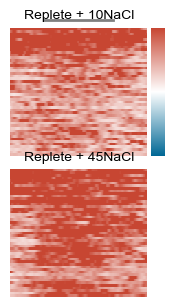

In [5]:
### 1A. Heatmaps — Replete Condition

f, ax1, ax2, cbar_ax = init_heatmap_figure()

# Replete + 10NaCl
heatmap_data_rep_10 = get_heatmap_data(snips_behav_smooth, x_array, "replete", "10NaCl")
replete_10_auc = get_auc(heatmap_data_rep_10)
make_heatmap(heatmap_data_rep_10, ax1, vlim, inf_bar=True)

# Replete + 45NaCl
heatmap_data_rep_45 = get_heatmap_data(snips_behav_smooth, x_array, "replete", "45NaCl")
replete_45_auc = get_auc(heatmap_data_rep_45)
make_heatmap(heatmap_data_rep_45, ax2, vlim, cbar_ax=cbar_ax)

ax1.set_title("Replete + 10NaCl", fontsize=10)
ax2.set_title("Replete + 45NaCl", fontsize=10)

if SAVE_FIGS:
    save_figure(f, "fig1_heatmap_movement_replete", FIGSFOLDER)

plt.tight_layout()
plt.show()

C:\Users\jmc010\AppData\Local\Temp\ipykernel_35256\2054532559.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


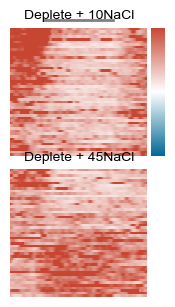

In [6]:
### 1B. Heatmaps — Deplete Condition

f, ax1, ax2, cbar_ax = init_heatmap_figure()

# Deplete + 10NaCl
heatmap_data_dep_10 = get_heatmap_data(snips_behav_smooth, x_array, "deplete", "10NaCl")
deplete_10_auc = get_auc(heatmap_data_dep_10)
make_heatmap(heatmap_data_dep_10, ax1, vlim, inf_bar=True)

# Deplete + 45NaCl
heatmap_data_dep_45 = get_heatmap_data(snips_behav_smooth, x_array, "deplete", "45NaCl")
deplete_45_auc = get_auc(heatmap_data_dep_45)
make_heatmap(heatmap_data_dep_45, ax2, vlim, cbar_ax=cbar_ax)

ax1.set_title("Deplete + 10NaCl", fontsize=10)
ax2.set_title("Deplete + 45NaCl", fontsize=10)

if SAVE_FIGS:
    save_figure(f, "fig1_heatmap_movement_deplete", FIGSFOLDER)

plt.tight_layout()
plt.show()

C:\Users\jmc010\AppData\Local\Temp\ipykernel_35256\3968760668.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


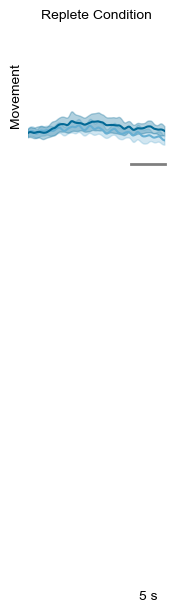

In [7]:
### 1C. Time Series Snips — Replete Condition

# Get animal-averaged snips for replete
snips_rep_10, snips_rep_45 = get_mean_snips(snips_behav_smooth, x_array, "replete")

f, ax = init_snips_figure()
plot_snips(snips_rep_10, snips_rep_45, ax, colors[0], colors[1], ylims)
ax.set_ylabel("Movement", fontsize=10)
ax.set_title("Replete Condition", fontsize=10)

if SAVE_FIGS:
    save_figure(f, "fig1_snips_movement_replete", FIGSFOLDER)

plt.tight_layout()
plt.show()

C:\Users\jmc010\AppData\Local\Temp\ipykernel_35256\2329505429.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


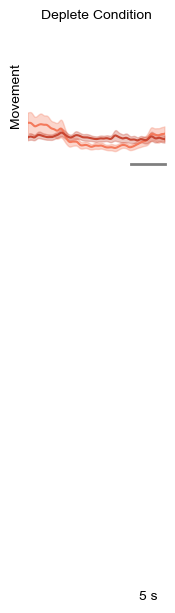

In [8]:
### 1D. Time Series Snips — Deplete Condition

# Get animal-averaged snips for deplete
snips_dep_10, snips_dep_45 = get_mean_snips(snips_behav_smooth, x_array, "deplete")

f, ax = init_snips_figure()
plot_snips(snips_dep_10, snips_dep_45, ax, colors[2], colors[3], ylims, scalebar=True)
ax.set_ylabel("Movement", fontsize=10)
ax.set_title("Deplete Condition", fontsize=10)

if SAVE_FIGS:
    save_figure(f, "fig1_snips_movement_deplete", FIGSFOLDER)

plt.tight_layout()
plt.show()

C:\Users\jmc010\AppData\Local\Temp\ipykernel_34152\587607648.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


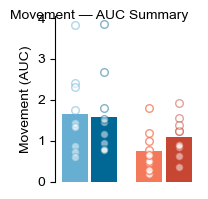


Figure 1 — Movement Summary Statistics
Replete + 10NaCl (n=10)        (n=10):    1.66 ± 0.29
Replete + 45NaCl (n=10)        (n=10):    1.58 ± 0.30
Deplete + 10NaCl (n=10)        (n=10):    0.75 ± 0.14
Deplete + 45NaCl (n=10)        (n=10):    1.09 ± 0.14


In [38]:
### 1E. AUC Summary — Bar Plot with Individual Data Points

# Organize AUCs by condition
replete_aucs = [get_auc(snips_rep_10), get_auc(snips_rep_45)]
deplete_aucs = [get_auc(snips_dep_10), get_auc(snips_dep_45)]
aucs = [replete_aucs, deplete_aucs]

f, ax = plot_auc_summary(aucs, colors, ylabel="Movement (AUC)")
f.suptitle("Movement — AUC Summary", fontsize=10)

if SAVE_FIGS:
    save_figure(f, "fig1_auc_movement_summary", FIGSFOLDER)

plt.tight_layout()
plt.show()

# Print summary statistics
auc_labels = [
    f"Replete + 10NaCl (n={len(snips_rep_10)})",
    f"Replete + 45NaCl (n={len(snips_rep_45)})",
    f"Deplete + 10NaCl (n={len(snips_dep_10)})",
    f"Deplete + 45NaCl (n={len(snips_dep_45)})"
]
auc_arrays = [replete_aucs[0], replete_aucs[1], deplete_aucs[0], deplete_aucs[1]]
print_auc_stats(auc_arrays, auc_labels, title="Figure 1 — Movement Summary Statistics")

## Organization

This notebook generates **Figure 1 (Movement Analysis)** only. Each subsequent figure has its own dedicated notebook:

- **figure_1_paper.ipynb**: Movement analysis (current)
- **figure_2_paper.ipynb**: Photometry (dopamine) analysis  
- **figure_3_paper.ipynb**: Neural-behavioral correlation
- **figure_4_paper.ipynb**: Transition analysis
- **figure_5_paper.ipynb**: Cluster analysis

All notebooks share common settings and functions from:
- `src/figure_config.py` — Colors, paths, parameters
- `src/figure_plotting.py` — Data extraction and plotting functions

This keeps each figure focused and manageable, while reducing code duplication.

In [9]:
# Configuration for Figure Saving
# ───────────────────────────────────────────────────────────────────────
# The SAVE_FIGS setting is loaded from figure_config.py
# Figures are saved in two formats:
#   - PDF for publication (vector format, smaller file size)
#   - PNG for presentations (raster format, high DPI for screen)
#
# All figures follow naming convention:
#   fig{number}_{description}.{pdf|png}
#
# Example:
#   fig1_heatmap_movement_replete.pdf
#   fig1_snips_movement_replete.png
# ───────────────────────────────────────────────────────────────────────

print(f"\nFigure saving is currently: {'ENABLED' if SAVE_FIGS else 'DISABLED'}")
print(f"Figure output folder: {FIGSFOLDER}")
if SAVE_FIGS:
    print("All generated figures will be saved in both PDF and PNG formats.")
else:
    print("To save figures, set SAVE_FIGS = True in src/figure_config.py")


Figure saving is currently: DISABLED
Figure output folder: ..\paper\figs
To save figures, set SAVE_FIGS = True in src/figure_config.py
